## Data reading and Data Insights

**Listening to motivational podcasts Participant: matmab5p, 16 days participation**

*Dataset:* Listening to motivational podcasts (A) vs Not listening to motivational podcasts (B) (continue daily routine normally) study

#### Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan

In [4]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__listening_to_motivational_podcasts__-_matmab5p_2025-05-21 12_34_22.378//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__listening_to_motivational_podcasts__-_matmab5p_2025-05-21 12_34_22.378//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: matmab5p
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [5]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: '7a793276-86eb-49ef-bd1f-80af65fcd02a'


#### Participation of the study

In [6]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  7a793276-86eb-49ef-bd1f-80af65fcd02a                  15


The study comprised a single participant, with a total participation period of 15 days.

#### Missing Values

In [7]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),            
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 7a793276-86eb-49ef-bd1f-80af65fcd02a ---

  Outcome:
    Start date:           2025-05-05
    End of expected 16d:  2025-05-20
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-12

  Mediators:
    Start date:           2025-05-05
    End of expected 16d:  2025-05-20
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-12


#### Remove Participants Who Joined Outside the Study

In [8]:
# df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
# df_mea.shape[0]

#### Data Preperation

In [9]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-05-20 19:32:20.490147+00:00,Mediators,7a793276-86eb-49ef-bd1f-80af65fcd02a,15,Listening to motivational podcasts!,NaN,NaN,NaN,NaN,6.0,5.0


In [10]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [11]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [12]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
29,2025-05-05 19:50:19.311879+00:00,Outcome,7a793276-86eb-49ef-bd1f-80af65fcd02a,0,Listening to motivational podcasts!,4.0,6.0,7.0,1.0,NaN,NaN
27,2025-05-06 18:58:27.482793+00:00,Outcome,7a793276-86eb-49ef-bd1f-80af65fcd02a,1,Listening to motivational podcasts!,7.0,6.0,7.0,1.0,NaN,NaN
25,2025-05-07 20:26:19.518999+00:00,Outcome,7a793276-86eb-49ef-bd1f-80af65fcd02a,2,Listening to motivational podcasts!,5.0,4.0,7.0,1.0,NaN,NaN
23,2025-05-08 19:41:06.976763+00:00,Outcome,7a793276-86eb-49ef-bd1f-80af65fcd02a,3,Listening to motivational podcasts!,5.0,4.0,8.0,1.0,NaN,NaN
21,2025-05-09 20:16:37.285695+00:00,Outcome,7a793276-86eb-49ef-bd1f-80af65fcd02a,4,Not listening to motivational podcasts!,6.0,5.0,1.0,7.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)     

#### Data Shape

In [13]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 15
Columns: 11


#### Data Types of columns

In [14]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [15]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()

        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),      
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 7a793276-86eb-49ef-bd1f-80af65fcd02a ---

  Outcome:
    Start date:           2025-05-05
    End of expected 16d:  2025-05-20
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-12

  Mediators:
    Start date:           2025-05-05
    End of expected 16d:  2025-05-20
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-12

  survey1_question1_response:
    Start date:           2025-05-05
    End of expected 16d:  2025-05-20
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-12

  survey1_question2_response:
    Start date:           2025-05-05
    End of expected 16d:  2025-05-20
    Expected days count:  16
    Completed days count: 15
    Missed days count:    1
    Missed dates:
       2025-05-12

  survey1_question3_response:
    Start date:           2025-05-05
  

#### Missing Values for Confirmations between 08.00 - 21.00

In [16]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=16, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 16 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 16 days have participation confirmations; no missing days found.


#### Summary Statistics

In [17]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             15.000000                   15.000000   
mean               7.533333                    5.400000   
std                4.926121                    1.055597   
min                0.000000                    4.000000   
25%                3.500000                    5.000000   
50%                8.000000                    5.000000   
75%               11.500000                    6.000000   
max               15.000000                    7.000000   

       survey1_question2_response  survey1_question3_response  \
count                   15.000000                   15.000000   
mean                     5.866667                    4.400000   
std                      0.990430                    3.312315   
min                      4.000000                    1.000000   
25%                      5.500000                    1.000000   
50%                      6.000000               

In [18]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 29 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            15 non-null     datetime64[ns, UTC]
 1   measurement_name            15 non-null     object             
 2   participant_id              15 non-null     object             
 3   current_day_of_study        15 non-null     int64              
 4   current_intervention_name   15 non-null     object             
 5   survey1_question1_response  15 non-null     float64            
 6   survey1_question2_response  15 non-null     float64            
 7   survey1_question3_response  15 non-null     float64            
 8   survey1_question4_response  15 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

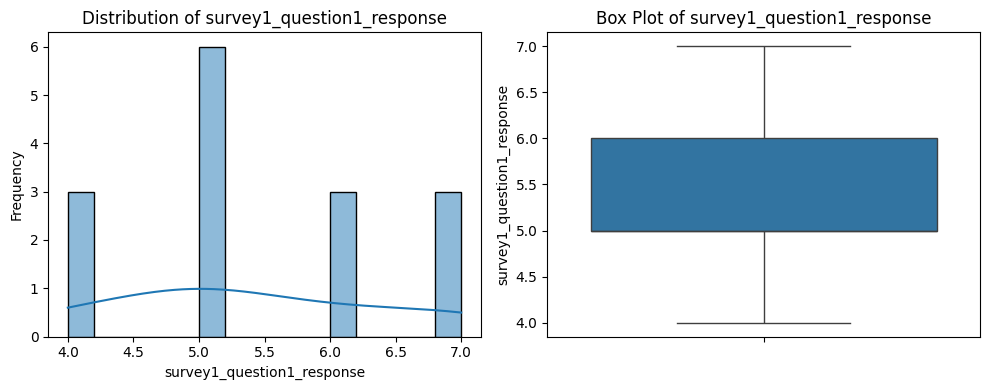

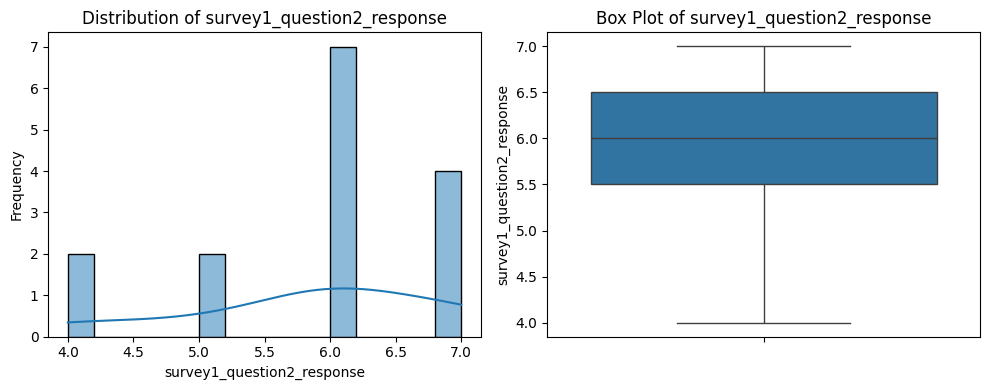

In [19]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

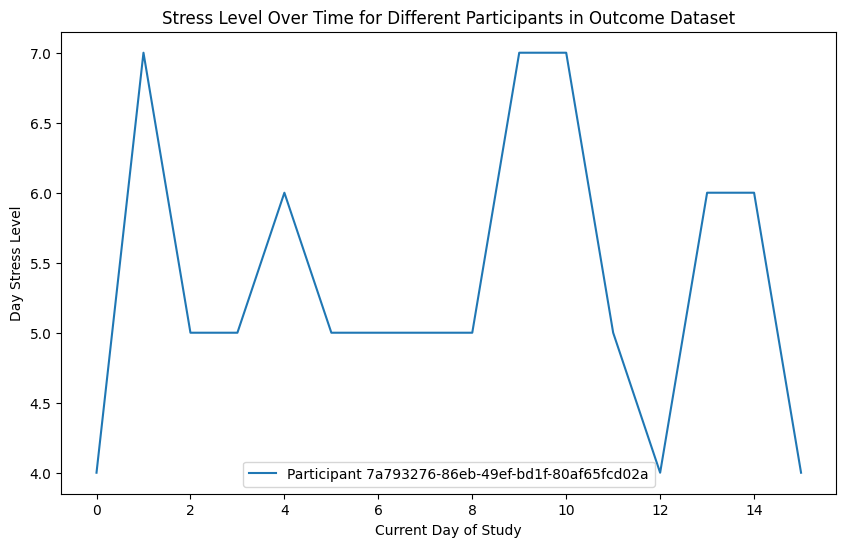

In [20]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6))

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()


#### Scatterplot

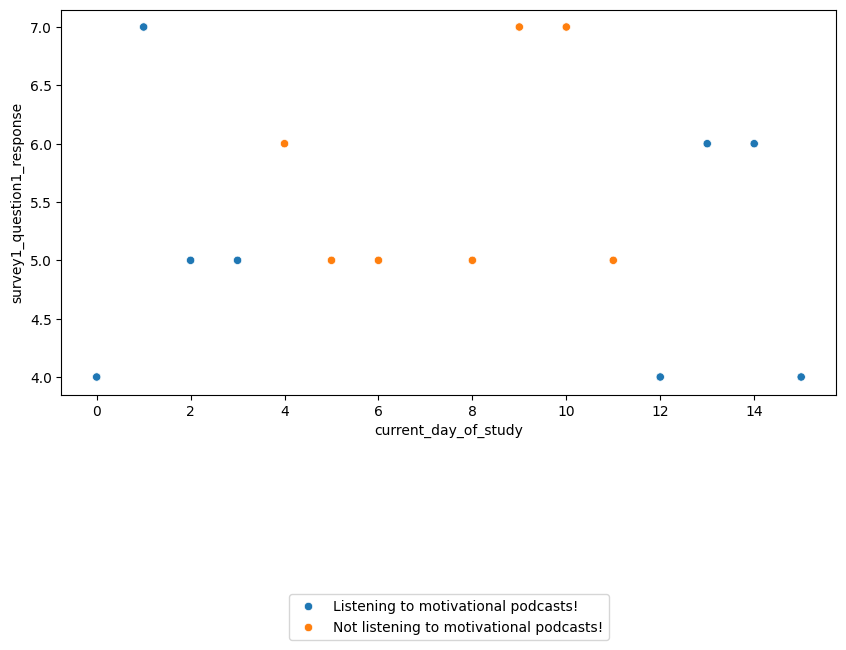

In [21]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))


#### Correlations

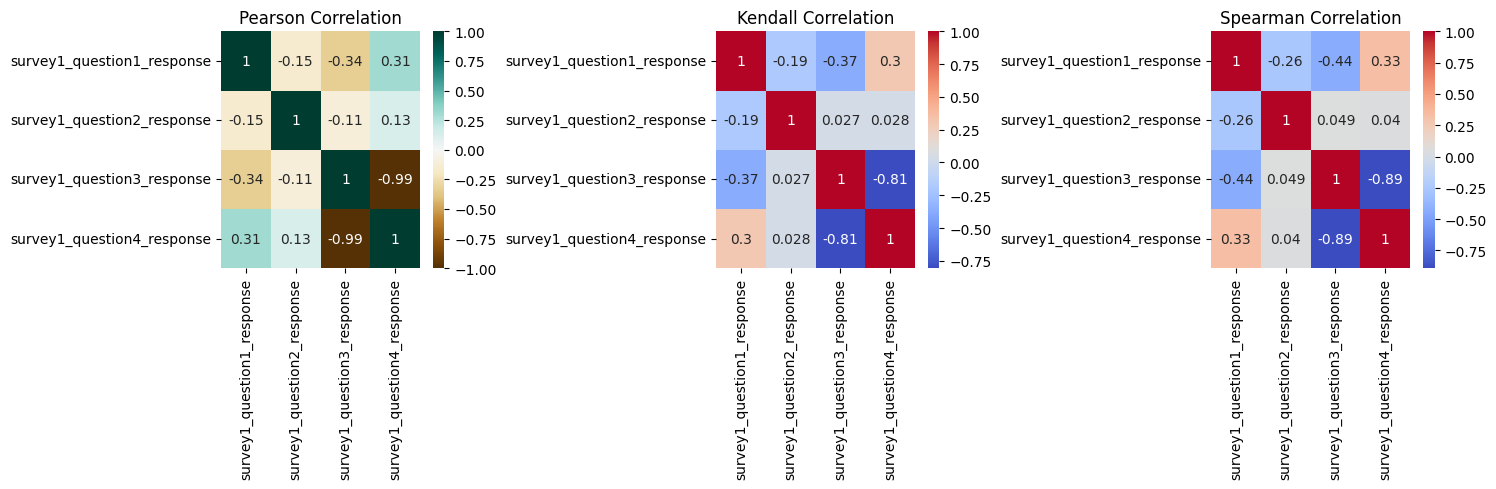

In [22]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Listening Motivational Podcasts vs Not Listening Motivational Podcasts

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)
        - Bayesian AR(1) Regression with Consecutive‐Day Adjustment
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Mean Imputation Method
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Latent Variable Method

#### Examination of Outcomes: Today Stress Level

In [23]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Listening to motivational podcasts!",
        "Not listening to motivational podcasts!"
    ])
]

motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to motivational podcasts!",
    'survey1_question1_response'
]
no_motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to motivational podcasts!",
    'survey1_question1_response'
]

n_motivational        = motivational.count()
n_no_motivational     = no_motivational.count()
std_motivational      = motivational.std(ddof=1)
std_no_motivational   = no_motivational.std(ddof=1)

print(f"Listening to motivational podcasts:                          n = {n_motivational}, std = {std_motivational:.2f}, mean = {motivational.mean():.2f}")
print(f"Not listening to motivational podcasts (daily routine normal): n = {n_no_motivational}, std = {std_no_motivational:.2f}, mean = {no_motivational.mean():.2f}\n")


Listening to motivational podcasts:                          n = 8, std = 1.13, mean = 5.12
Not listening to motivational podcasts (daily routine normal): n = 7, std = 0.95, mean = 5.71



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [24]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Listening to motivational podcasts!",
        "Not listening to motivational podcasts!"
    ])
]

motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to motivational podcasts!",
    'survey1_question2_response'
]
no_motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to motivational podcasts!",
    'survey1_question2_response'
]

n_motivational        = motivational.count()
n_no_motivational     = no_motivational.count()
std_motivational      = motivational.std(ddof=1)
std_no_motivational   = no_motivational.std(ddof=1)

print(f"Listening to motivational podcasts:                          n = {n_motivational}, std = {std_motivational:.2f}, mean = {motivational.mean():.2f}")
print(f"Not listening to motivational podcasts (daily routine normal): n = {n_no_motivational}, std = {std_no_motivational:.2f}, mean = {no_motivational.mean():.2f}\n")


Listening to motivational podcasts:                          n = 8, std = 1.28, mean = 5.75
Not listening to motivational podcasts (daily routine normal): n = 7, std = 0.58, mean = 6.00



#### Examination of Outcomes: Mean Stress-Relief Score for Listening to Motivational Podcasts! (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much listening to motivational podcasts alleviated participants’ stress on days they performed.

In [25]:
df_mea.survey1_question3_text[0]

"Did your miracle stress-shrinking method (listening to the motivational podcast) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes? <b>(1 = Not helpful at all to 10 = I'm practically levitating with calmness) <i>(Answer ONLY if you have listened to motivational podcasts!)</i></b>"

In [26]:
# "Did your miracle stress-shrinking method (listening to the motivational podcast) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes? <b>(1 = Not helpful at all to 10 = I'm practically levitating with calmness) (Answer ONLY if you have listened to motivational podcasts!)"
mean_q3_listening_motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to motivational podcasts!",
    'survey1_question3_response'
].mean()
mean_q3_listening_motivational.item()


7.375

**Mean Self-Improvement Score for Listening to Motivational Podcasts (Q3): 7.375:**
On days when the participant listened to motivational podcasts, he rated Question 3—“Did your miracle stress-shrinking method (listening to the motivational podcast) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes?”—an average of **7.38 out of 10**, indicating that motivational podcasts provided a substantial benefit.


#### Examination of Outcomes: Mean Stress-Management Difficulty Without Listening to Motivational Podcasts (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not listen to motivational podcasts.

In [27]:
df_mea.survey1_question4_text[0]

"When you skipped the method (not listening to the motivational podcast) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b> (1 = Easy breezy to 10 = Send help, I'm barely holding it together!)<i> (Answer ONLY if you have NOT listened to motivational podcasts!)</i></b>"

In [28]:
# "When you skipped the method (not listening to the motivational podcast) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b> (1 = Easy breezy to 10 = Send help, I'm barely holding it together!)<i> (Answer ONLY if you have NOT listened to motivational podcasts!)</i></b>"
mean_q4_no_listening_motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to motivational podcasts!",
    'survey1_question4_response'
].mean()
mean_q4_no_listening_motivational.item()


6.428571428571429

**Mean Stress-Management Difficulty Score Without Listening to Motivational Podcasts (Q4): 6.43:**
On days when the participant did not listen to motivational podcasts, he rated Question 4—“When you skipped the method (not listening to the motivational podcast) today, did managing stress feel more like ‘breezing through a sunny park’ or ‘juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles’?”—an average of **6.43 out of 10**, indicating that going without motivational podcasts posed a moderate challenge in managing stress.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [29]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Listening to motivational podcasts!", "Not listening to motivational podcasts!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Listening to motivational podcasts!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.083
Model:                                    OLS   Adj. R-squared:                  0.013
Method:                         Least Squares   F-statistic:                     1.178
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.297
Time:                                22:52:14   Log-Likelihood:                -20.928
No. Observations:                          15   AIC:                             45.86
Df Residuals:                              13   BIC:                             47.27
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [30]:
# GLSAR Regression with AR(1) errors (Feasible GLS)
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.051
Model:                                  GLSAR   Adj. R-squared:                 -0.028
Method:                         Least Squares   F-statistic:                    0.6416
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.439
Time:                                22:52:14   Log-Likelihood:                -19.002
No. Observations:                          14   AIC:                             42.00
Df Residuals:                              12   BIC:                             43.28
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


#### Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators

In [31]:
def run_model(fac_cols, beta_names):
    out = df_mea[df_mea['measurement_name'] == 'Outcome']
    med = df_mea[df_mea['measurement_name'] == 'Mediators']
    data = (
        pd.merge(
            out[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']],
            med[['current_day_of_study'] + fac_cols] if fac_cols else out[['current_day_of_study']],
            on='current_day_of_study',
            how='inner'
        ).dropna().sort_values('current_day_of_study').reset_index(drop=True)
    )
    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(int).values
    n = len(data)
    fac_arrays = [data[col].values for col in fac_cols] if fac_cols else []

    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        betas = [pm.Normal(beta_name, mu=0, sigma=1) for beta_name in beta_names]
        rho = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = beta0 + beta_int * interv
        for beta, fac in zip(betas, fac_arrays):
            mu += beta * fac
        pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])
        for t in range(1, n):
            adjustment = rho * (y[t-1] - mu[t-1])
            pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9, return_inferencedata=True)
    summary = az.summary(trace, var_names=['beta_int'] + beta_names + ['rho', 'sigma'], hdi_prob=0.95)
    print(summary)
    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()
    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")
    prob = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(Stress reduction of listening to motivational podcasts ≥ 0.5) = {prob:.2%}\n")

print("Model result with neither fac1 nor fac2 (intervention only):")
run_model([], [])

print("Model result with only fac1:")
run_model(['survey2_question1_response'], ['beta_f1'])

print("Model result with only fac2:")
run_model(['survey2_question2_response'], ['beta_f2'])

print("Model result with both fac1 and fac2:")
run_model(['survey2_question1_response', 'survey2_question2_response'], ['beta_f1', 'beta_f2'])

Model result with neither fac1 nor fac2 (intervention only):


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 146 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.445  0.541    -1.481      0.632      0.025    0.025     456.0   
rho      -0.003  0.336    -0.663      0.670      0.027    0.025     188.0   
sigma     1.118  0.225     0.692      1.517      0.011    0.010     498.0   

          ess_tail  r_hat  
beta_int     339.0   1.00  
rho          103.0   1.01  
sigma        458.0   1.00  
P(beta_int ≤ –0.5) = 46.20%
P(–0.5 < beta_int < 0) = 35.00%
P(beta_int ≥ 0) = 18.80%
P(Stress reduction of listening to motivational podcasts ≥ 0.5) = 46.20%

Model result with only fac1:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 502 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.065  0.538    -0.957      1.158      0.023    0.024     523.0   
beta_f1   0.888  0.374     0.175      1.616      0.024    0.013     246.0   
rho       0.331  0.362    -0.344      0.966      0.021    0.013     291.0   
sigma     0.977  0.210     0.615      1.390      0.011    0.013     394.0   

          ess_tail  r_hat  
beta_int     438.0   1.00  
beta_f1      419.0   1.01  
rho          369.0   1.00  
sigma        462.0   1.01  
P(beta_int ≤ –0.5) = 14.00%
P(–0.5 < beta_int < 0) = 31.20%
P(beta_int ≥ 0) = 54.80%
P(Stress reduction of listening to motivational podcasts ≥ 0.5) = 14.00%

Model result with only fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 455 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.194  0.659    -1.500      1.014      0.035    0.025     357.0   
beta_f2   0.333  0.383    -0.488      1.046      0.035    0.016     127.0   
rho       0.063  0.338    -0.567      0.707      0.018    0.011     341.0   
sigma     1.142  0.232     0.785      1.621      0.012    0.014     387.0   

          ess_tail  r_hat  
beta_int     422.0   1.00  
beta_f2      328.0   1.02  
rho          394.0   1.00  
sigma        366.0   1.00  
P(beta_int ≤ –0.5) = 32.00%
P(–0.5 < beta_int < 0) = 29.70%
P(beta_int ≥ 0) = 38.30%
P(Stress reduction of listening to motivational podcasts ≥ 0.5) = 32.00%

Model result with both fac1 and fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 647 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.125  0.621    -0.996      1.401      0.030    0.020     426.0   
beta_f1   0.877  0.359     0.190      1.601      0.018    0.012     403.0   
beta_f2   0.173  0.344    -0.532      0.830      0.021    0.015     272.0   
rho       0.359  0.379    -0.351      0.989      0.027    0.015     214.0   
sigma     0.996  0.209     0.636      1.433      0.013    0.009     237.0   

          ess_tail  r_hat  
beta_int     454.0   1.01  
beta_f1      508.0   1.01  
beta_f2      158.0   1.00  
rho          173.0   1.02  
sigma        103.0   1.01  
P(beta_int ≤ –0.5) = 15.40%
P(–0.5 < beta_int < 0) = 26.90%
P(beta_int ≥ 0) = 57.70%
P(Stress reduction of listening to motivational podcasts ≥ 0.5) = 15.40%



#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 148 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.364  0.700    -1.753      0.896      0.038    0.049     379.0   
rho       0.050  0.370    -0.560      0.885      0.023    0.018     266.0   
sigma     1.224  0.299     0.729      1.815      0.018    0.015     324.0   

          ess_tail  r_hat  
beta_int     382.0   1.00  
rho          144.0   1.01  
sigma        322.0   1.01  
P(beta_int ≤ –0.5) = 41.10%
P(–0.5 < beta_int < 0) = 33.00%
P(beta_int ≥ 0) = 25.90%


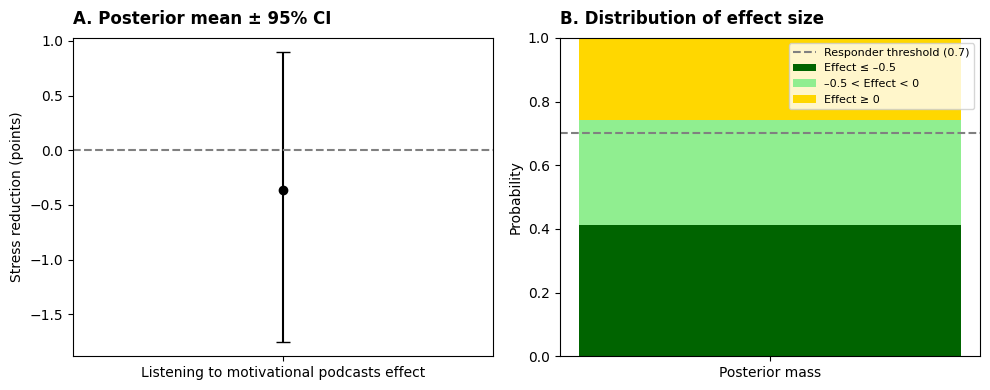

In [32]:
outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
data = (
    outcome_data[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']]
    .dropna()
    .sort_values('current_day_of_study')
    .reset_index(drop=True)
)

y      = data['survey1_question1_response'].values
interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(int).values
n      = len(data)

mad = np.median(np.abs(y - np.median(y)))
scale = max(mad, 2.0)

with pm.Model() as model:
    beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)   
    beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)   
    rho      = pm.Uniform('rho',       lower=-1, upper=1)         
    sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)        

    mu = beta0 + beta_int * interv

    pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])

    for t in range(1, n):
        adjustment = rho * (y[t-1] - mu[t-1])
        pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])

    trace = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True
    )

summary = az.summary(trace, var_names=['beta_int', 'rho', 'sigma'], hdi_prob=0.95)
print(summary)

beta_samples = trace.posterior['beta_int'].values.flatten()

p_le_neg05 = (beta_samples <= -0.5).mean()
p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
p_ge0      = (beta_samples >= 0).mean()

print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

mean_beta = summary.loc['beta_int', 'mean']
hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

ax = axes[0]
ax.errorbar(0, mean_beta,
            yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
            fmt='o', capsize=5, color='black')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks([0])
ax.set_xticklabels(['Listening to motivational podcasts effect'])
ax.set_ylabel('Stress reduction (points)')
ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

ax = axes[1]
ax.bar(0, p_le_neg05, width=0.6, color='darkgreen',  label='Effect ≤ –0.5')
ax.bar(0, p_between,  width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < Effect < 0')
ax.bar(0, p_ge0,      width=0.6, bottom=p_le_neg05+p_between, color='gold', label='Effect ≥ 0')
ax.axhline(0.7, color='gray', linestyle='--', label='Responder threshold (0.7)')
ax.set_xticks([0])
ax.set_xticklabels(['Posterior mass'])
ax.set_ylim(0, 1)
ax.set_ylabel('Probability')
ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

#### Bayesian AR(1) Regression with Consecutive‐Day Adjustment

Only intervention:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 111 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.421  0.517    -1.466      0.541      0.022    0.015     541.0   
rho       0.131  0.343    -0.484      0.829      0.013    0.011     679.0   
sigma     1.140  0.236     0.732      1.598      0.010    0.010     607.0   

          ess_tail  r_hat  
beta_int     592.0    1.0  
rho          495.0    1.0  
sigma        630.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 44.40%
P(beta_int ≤ –0.5) = 44.40%
P(–0.5 < beta_int < 0) = 34.10%
P(beta_int ≥ 0) = 21.50%


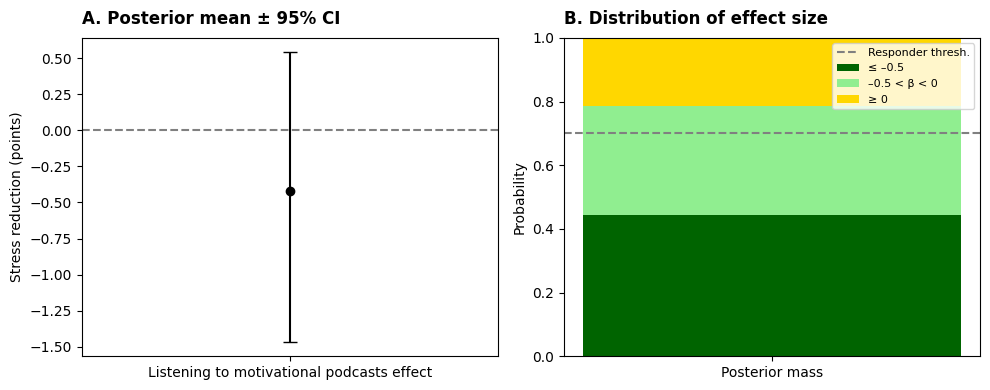


Intervention + fac1:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 431 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.173  0.531    -0.785      1.220      0.026    0.020     422.0   
rho       0.448  0.317    -0.117      1.000      0.014    0.011     437.0   
sigma     0.929  0.191     0.602      1.295      0.008    0.008     503.0   
beta_f1   0.938  0.326     0.279      1.539      0.018    0.012     333.0   

          ess_tail  r_hat  
beta_int     518.0   1.00  
rho          281.0   1.01  
sigma        586.0   1.00  
beta_f1      495.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 9.30%
P(beta_int ≤ –0.5) = 9.30%
P(–0.5 < beta_int < 0) = 29.00%
P(beta_int ≥ 0) = 61.70%


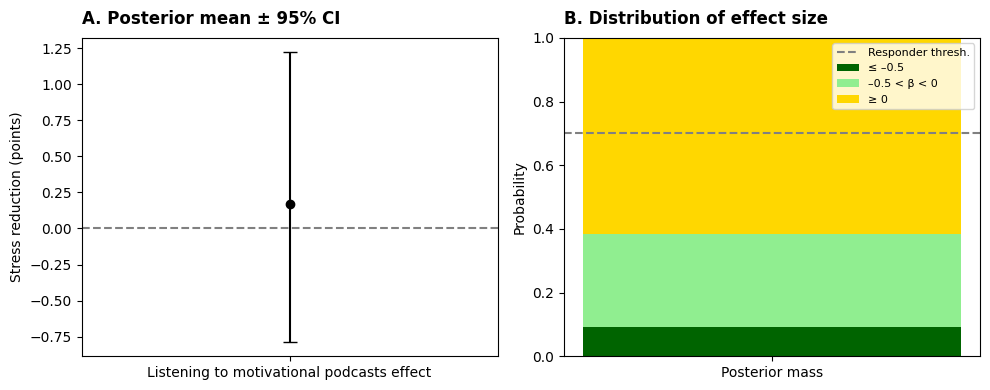


Intervention + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 432 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.073  0.663    -1.372      1.243      0.032    0.025     424.0   
rho       0.105  0.348    -0.484      0.830      0.018    0.016     350.0   
sigma     1.144  0.231     0.744      1.578      0.011    0.008     520.0   
beta_f2   0.369  0.366    -0.344      1.019      0.021    0.015     296.0   

          ess_tail  r_hat  
beta_int     435.0   1.01  
rho          207.0   1.00  
sigma        610.0   1.01  
beta_f2      301.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 27.00%
P(beta_int ≤ –0.5) = 27.00%
P(–0.5 < beta_int < 0) = 28.20%
P(beta_int ≥ 0) = 44.80%


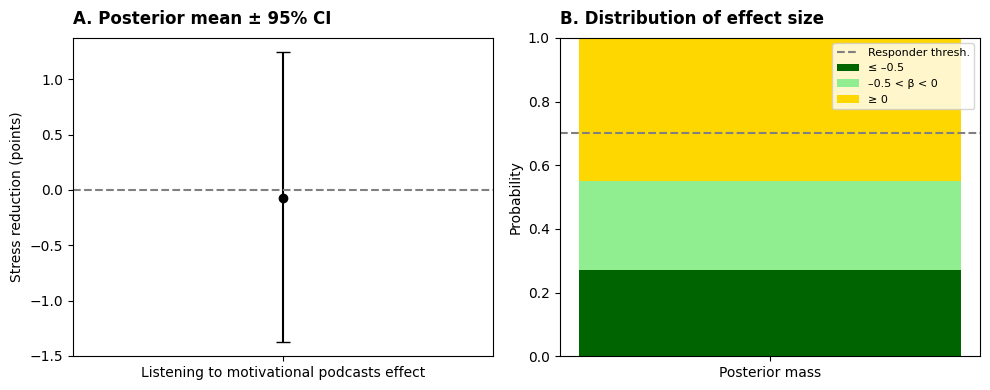


Intervention + fac1 + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 449 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.259  0.590    -0.799      1.416      0.028    0.019     452.0   
rho       0.412  0.324    -0.194      0.967      0.015    0.011     470.0   
sigma     0.988  0.217     0.625      1.410      0.011    0.009     420.0   
beta_f1   0.919  0.405     0.143      1.699      0.022    0.017     342.0   
beta_f2   0.110  0.355    -0.595      0.751      0.016    0.017     476.0   

          ess_tail  r_hat  
beta_int     619.0    1.0  
rho          584.0    1.0  
sigma        543.0    1.0  
beta_f1      478.0    1.0  
beta_f2      481.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 10.50%
P(beta_int ≤ –0.5) = 10.50%
P(–0.5 < beta_int < 0) = 21.60%
P(beta_int ≥ 0) = 67.90%


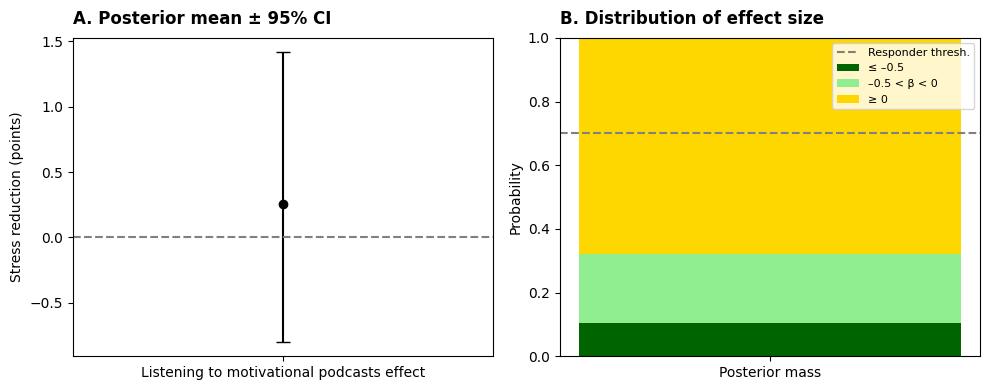

(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
 beta_int  0.259  0.590    -0.799      1.416      0.028    0.019     452.0   
 rho       0.412  0.324    -0.194      0.967      0.015    0.011     470.0   
 sigma     0.988  0.217     0.625      1.410      0.011    0.009     420.0   
 beta_f1   0.919  0.405     0.143      1.699      0.022    0.017     342.0   
 beta_f2   0.110  0.355    -0.595      0.751      0.016    0.017     476.0   
 
           ess_tail  r_hat  
 beta_int     619.0    1.0  
 rho          584.0    1.0  
 sigma        543.0    1.0  
 beta_f1      478.0    1.0  
 beta_f2      481.0    1.0  )

In [33]:
def run_ar1_model(df_mea, use_fac1=False, use_fac2=False):
    days_full = pd.DataFrame({'current_day_of_study': np.arange(0, 16)})

    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome'][
        ['current_day_of_study',
         'survey1_question1_response',   
         'current_intervention_name']
    ]
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators'][
        ['current_day_of_study',
         'survey2_question1_response',   
         'survey2_question2_response']   
    ]

    data = (
        days_full
        .merge(outcome_data,  on='current_day_of_study', how='left')
        .merge(mediator_data, on='current_day_of_study', how='left')
        .sort_values('current_day_of_study')
        .reset_index(drop=True)
    )

    days   = data['current_day_of_study'].values
    y      = data['survey1_question1_response'].values.astype(float)  
    n      = len(y)  

    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(float).fillna(0).values

    if use_fac1:
        fac1 = data['survey2_question1_response'].values.astype(float)
        fac1 = np.nan_to_num(fac1, nan=0.0)
    else:
        fac1 = np.zeros_like(days, dtype=float)

    if use_fac2:
        fac2 = data['survey2_question2_response'].values.astype(float)
        fac2 = np.nan_to_num(fac2, nan=0.0)
    else:
        fac2 = np.zeros_like(days, dtype=float)

    obs_mask = ~np.isnan(y)
    consec   = np.zeros(n, dtype=float)
    consec[1:] = (obs_mask[1:] & obs_mask[:-1]).astype(float)

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if use_fac1:
            beta_f1  = pm.Normal('beta_f1',  mu=0, sigma=10)
        if use_fac2:
            beta_f2  = pm.Normal('beta_f2',  mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if use_fac1:
            mu = mu + beta_f1 * fac1
        if use_fac2:
            mu = mu + beta_f2 * fac2

        y_tt      = pt.constant(y)            
        mu_tt     = mu
        consec_tt = pt.constant(consec)

        def ar1_step(y_prev, mu_prev, mu_curr, consec_prev, rho):
            ar_term = pt.switch(pt.eq(consec_prev, 1.0), rho * (y_prev - mu_prev), 0.0)
            return mu_curr + ar_term

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu_tt[:-1], mu_tt[1:], consec_tt[:-1]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu_tt[0]], y_pred_scan], axis=0)

        y_obs_masked = np.ma.masked_invalid(y)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_obs_masked)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if use_fac1:
        var_names.append('beta_f1')
    if use_fac2:
        var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Listening to motivational podcasts effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left',
                 pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold',       label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left',
                 pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return trace, summary

print("Only intervention:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=False)

print("\nIntervention + fac1:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=False)

print("\nIntervention + fac2:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=True)

print("\nIntervention + fac1 + fac2:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=True)

#### Bayesian AR(1) Model of Daily Stress Response to Listening to motivational podcasts and Mediators - Mean Imputation Method

In [34]:
imputed_data_o = df_mea[df_mea['measurement_name'] == 'Outcome'].copy()
imputed_data_o['current_day_of_study'] = imputed_data_o['current_day_of_study'].astype(int)

days = pd.DataFrame({'current_day_of_study': range(0, 16)})

imputed_complete_o = days.merge(
    imputed_data_o, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)

imputed_data_m = df_mea[df_mea['measurement_name'] == 'Mediators'].copy()
imputed_data_m['current_day_of_study'] = imputed_data_m['current_day_of_study'].astype(int)

imputed_complete_m = days.merge(
    imputed_data_m, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_m['measurement_name'].fillna('Mediators', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_20080\224566006.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_20080\224566006.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [35]:
df_o = imputed_complete_o.copy()
df_m = imputed_complete_m.copy()
pattern = (
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 
)
txt = {
    'A': "Listening to motivational podcasts!",
    'B': "Not listening to motivational podcasts!"
}

df_unique_o = (
    df_o
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_o = (
    df_unique_o
    .reindex(range(0, 16))                     
    .reset_index()                            
)

mask_o = df_fill_o['current_intervention_name'].isna()
df_fill_o.loc[mask_o, 'current_intervention_name'] = (
    df_fill_o.loc[mask_o, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)
df_unique_m = (
    df_m
    .sort_values('current_day_of_study')      
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_m = (
    df_unique_m
    .reindex(range(0, 16))                     
    .reset_index()                             
)

mask_m = df_fill_m['current_intervention_name'].isna()
df_fill_m.loc[mask_m, 'current_intervention_name'] = (
    df_fill_m.loc[mask_m, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

In [36]:
df_mean_imp_o = df_fill_o.copy()
df_mean_imp_m = df_fill_m.copy()

df_mean_imp_o['survey1_question1_response'] = (
    df_mean_imp_o
    .groupby('current_intervention_name')['survey1_question1_response']
    .transform(lambda grp: grp.fillna(grp.mean()))
)
cols_to_impute = [
    'survey2_question1_response',
    'survey2_question2_response'
]

for col in cols_to_impute:
    df_mean_imp_m[col] = (
        df_mean_imp_m
        .groupby('current_intervention_name')[col]
        .transform(lambda grp: grp.fillna(grp.mean()))
    )

In [37]:
def run_model(fac_cols, beta_names):
    out = df_mean_imp_o.copy()
    med = df_mean_imp_m.copy()
  
    data = (
        pd.merge(
            out[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']],
            med[['current_day_of_study'] + fac_cols] if fac_cols else out[['current_day_of_study']],
            on='current_day_of_study',
            how='inner'
        ).dropna().sort_values('current_day_of_study').reset_index(drop=True)
    )
    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(int).values
    n = len(data)
    fac_arrays = [data[col].values for col in fac_cols] if fac_cols else []

    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        betas = [pm.Normal(beta_name, mu=0, sigma=1) for beta_name in beta_names]
        rho = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = beta0 + beta_int * interv
        for beta, fac in zip(betas, fac_arrays):
            mu += beta * fac
        pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])
        for t in range(1, n):
            adjustment = rho * (y[t-1] - mu[t-1])
            pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9, return_inferencedata=True)
    summary = az.summary(trace, var_names=['beta_int'] + beta_names + ['rho', 'sigma'], hdi_prob=0.95)
    print(summary)
    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()
    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")
    prob = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(Stress reduction of listening to motivational podcasts ≥ 0.5) = {prob:.2%}\n")

print("Model result with neither fac1 nor fac2 (intervention only):")
run_model([], [])

print("Model result with only fac1:")
run_model(['survey2_question1_response'], ['beta_f1'])

print("Model result with only fac2:")
run_model(['survey2_question2_response'], ['beta_f2'])

print("Model result with both fac1 and fac2:")
run_model(['survey2_question1_response', 'survey2_question2_response'], ['beta_f1', 'beta_f2'])

Model result with neither fac1 nor fac2 (intervention only):


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 75 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.482  0.464    -1.412      0.394      0.022    0.017     442.0   
rho      -0.075  0.337    -0.724      0.596      0.015    0.014     503.0   
sigma     1.090  0.221     0.706      1.541      0.010    0.008     501.0   

          ess_tail  r_hat  
beta_int     454.0   1.00  
rho          309.0   1.00  
sigma        675.0   1.01  
P(beta_int ≤ –0.5) = 45.60%
P(–0.5 < beta_int < 0) = 40.60%
P(beta_int ≥ 0) = 13.80%
P(Stress reduction of listening to motivational podcasts ≥ 0.5) = 45.60%

Model result with only fac1:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 338 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.054  0.521    -0.871      1.083      0.025    0.017     435.0   
beta_f1   0.849  0.361     0.195      1.578      0.027    0.012     177.0   
rho       0.282  0.382    -0.342      0.989      0.031    0.017     156.0   
sigma     0.961  0.196     0.632      1.332      0.011    0.012     356.0   

          ess_tail  r_hat  
beta_int     710.0   1.00  
beta_f1      458.0   1.02  
rho          264.0   1.02  
sigma        349.0   1.00  
P(beta_int ≤ –0.5) = 15.10%
P(–0.5 < beta_int < 0) = 30.70%
P(beta_int ≥ 0) = 54.20%
P(Stress reduction of listening to motivational podcasts ≥ 0.5) = 15.10%

Model result with only fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 382 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.189  0.639    -1.308      1.081      0.036    0.029     332.0   
beta_f2   0.288  0.356    -0.340      1.052      0.024    0.017     221.0   
rho      -0.044  0.309    -0.752      0.508      0.014    0.013     465.0   
sigma     1.076  0.189     0.727      1.451      0.010    0.007     391.0   

          ess_tail  r_hat  
beta_int     362.0   1.00  
beta_f2      214.0   1.01  
rho          450.0   1.01  
sigma        484.0   1.01  
P(beta_int ≤ –0.5) = 31.40%
P(–0.5 < beta_int < 0) = 27.60%
P(beta_int ≥ 0) = 41.00%
P(Stress reduction of listening to motivational podcasts ≥ 0.5) = 31.40%

Model result with both fac1 and fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 501 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.186  0.624    -1.077      1.399      0.029    0.024     443.0   
beta_f1   0.843  0.371     0.140      1.529      0.021    0.011     308.0   
beta_f2   0.139  0.305    -0.465      0.719      0.014    0.015     451.0   
rho       0.282  0.388    -0.379      0.991      0.026    0.020     232.0   
sigma     0.957  0.193     0.626      1.351      0.008    0.006     558.0   

          ess_tail  r_hat  
beta_int     556.0   1.00  
beta_f1      450.0   1.01  
beta_f2      507.0   1.01  
rho          308.0   1.01  
sigma        645.0   1.00  
P(beta_int ≤ –0.5) = 12.90%
P(–0.5 < beta_int < 0) = 23.70%
P(beta_int ≥ 0) = 63.40%
P(Stress reduction of listening to motivational podcasts ≥ 0.5) = 12.90%



#### Bayesian AR(1) Model of Daily Stress Response to Listening to motivational podcasts and Mediators - Latent Variable Method

In [38]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    all_days = pd.DataFrame({'current_day_of_study': np.arange(0, 16)})
    outcome_data = pd.merge(all_days, outcome_data[merge_cols], on='current_day_of_study', how='left')
    if mediator_cols:
        mediator_data = pd.merge(all_days,
                                  mediator_data[['current_day_of_study'] + mediator_cols],
                                  on='current_day_of_study', how='left')
    else:
        mediator_data = all_days.copy()

    data = (pd.merge(outcome_data, mediator_data, on='current_day_of_study', how='left')
              .sort_values('current_day_of_study')
              .reset_index(drop=True))

    y_obs_raw = data['survey1_question1_response'].values
    y_obs = y_obs_raw.astype(float)
    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(float).fillna(0.0)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None
    n = len(y_obs)

    nan_idx = np.isnan(y_obs)
    obs_idx = ~nan_idx
    missing_idx = np.where(nan_idx)[0].tolist()

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho   = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * pt.as_tensor_variable(np.nan_to_num(fac1, nan=0.0))
        if include_fac2:
            mu = mu + beta_f2 * pt.as_tensor_variable(np.nan_to_num(fac2, nan=0.0))

        y_latent = pm.Normal('y_latent', mu=0, sigma=10, shape=len(missing_idx))

        y_filled = pt.zeros(n)
        y_filled = pt.set_subtensor(y_filled[missing_idx], y_latent)
        y_filled = pt.set_subtensor(y_filled[obs_idx], y_obs[obs_idx])

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_filled[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1
        )
        y_pred = pt.concatenate([mu[:1], y_pred_scan], axis=0)

        pm.Normal('y_obs',
                  mu=y_pred[obs_idx],
                  sigma=sigma,
                  observed=y_obs[obs_idx])

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9,
                          return_inferencedata=True)

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1: var_names.append('beta_f1')
    if include_fac2: var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 139 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.490  0.499    -1.479      0.532      0.025    0.021     408.0   
rho      -0.008  0.270    -0.580      0.518      0.023    0.025     210.0   
sigma     1.122  0.231     0.758      1.573      0.012    0.012     424.0   

          ess_tail  r_hat  
beta_int     465.0   1.01  
rho          103.0   1.01  
sigma        462.0   1.00  
P(beta_int ≤ –0.5) = 48.10%
P(–0.5 < beta_int < 0) = 37.20%
P(beta_int ≥ 0) = 14.70%
Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 510 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.061  0.540    -1.005      1.147      0.026    0.018     448.0   
rho       0.179  0.338    -0.312      0.993      0.024    0.025     215.0   
sigma     0.965  0.186     0.668      1.354      0.009    0.008     460.0   
beta_f1   0.864  0.371     0.155      1.578      0.020    0.012     345.0   

          ess_tail  r_hat  
beta_int     475.0   1.01  
rho          190.0   1.00  
sigma        459.0   1.00  
beta_f1      495.0   1.00  
P(beta_int ≤ –0.5) = 15.00%
P(–0.5 < beta_int < 0) = 30.70%
P(beta_int ≥ 0) = 54.30%
Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 520 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.106  0.625    -1.204      1.158      0.034    0.018     340.0   
rho       0.004  0.252    -0.544      0.488      0.015    0.015     306.0   
sigma     1.118  0.222     0.732      1.569      0.013    0.008     275.0   
beta_f2   0.397  0.375    -0.296      1.144      0.019    0.013     376.0   

          ess_tail  r_hat  
beta_int     458.0   1.00  
rho          228.0   1.01  
sigma        355.0   1.01  
beta_f2      520.0   1.00  
P(beta_int ≤ –0.5) = 26.20%
P(–0.5 < beta_int < 0) = 29.10%
P(beta_int ≥ 0) = 44.70%
Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 649 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.197  0.650    -1.088      1.499      0.033    0.023     400.0   
rho       0.201  0.327    -0.328      0.903      0.021    0.010     239.0   
sigma     0.992  0.217     0.636      1.420      0.010    0.012     493.0   
beta_f1   0.825  0.384     0.007      1.524      0.023    0.013     290.0   
beta_f2   0.190  0.374    -0.572      0.888      0.018    0.022     458.0   

          ess_tail  r_hat  
beta_int     617.0    1.0  
rho          372.0    1.0  
sigma        403.0    1.0  
beta_f1      486.0    1.0  
beta_f2      443.0    1.0  
P(beta_int ≤ –0.5) = 14.00%
P(–0.5 < beta_int < 0) = 24.00%
P(beta_int ≥ 0) = 62.00%
